CMPE 462 Project

Note: Throughout this notebook, you are **not obliged to** fill any function. Provided function headers or codes aim to help you to find a way to the solution. You are free to delete them if that helps.

# Question: Linear Regression

Suppose we are given the following model 
$$
y_i \approx m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{i=1}^K b_k \cos(\omega_k x_i)
$$

Show that this problem can be reduced to a least squares problem of form
$$
y \approx A(\omega, K) \theta
$$
where the design matrix $A(\omega, K)$ is determined solely by the frquency parameters $\omega$ and the remaining parameters can be organized as a vector $\theta = (m, a_{1:K}, b_{1:K})$. 


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd


## Write a program that generates data from the above model

In [3]:
# This data is generated for K=4,N=50,m=0.2. It is distorted with a noise as well. You may try to obtain a similar plot or
# generate a different one.
N=50; K=4; m = np.array([0.2]).reshape(1,1)

x = (np.random.rand(N)*2-1).reshape(N,1)
# Select a and b coefficients
a = (np.random.rand(K)*2-1).reshape(K,1)
b = (np.random.rand(K)*2-1).reshape(K,1)
om_true = np.array([0,np.pi/2,np.pi,np.pi*3/2]).reshape(K,1)
noise = np.random.normal(0, 0.5, N).reshape(N,1)

# Create design matrix
A = np.zeros((N,K*2+1))
for i in x:
    sin = np.sin(np.dot(om_true,i))
    cos = np.cos(np.dot(om_true,i))
    A[np.where(x == i)[0]] = i
    A[np.where(x == i)[0],1:(K+1)] = sin
    A[np.where(x == i)[0],(K+1):(K*2+1)] = cos
# Create parameter vector
theta = np.vstack((np.vstack((m,a)),b))
y = np.dot(A,theta) + noise

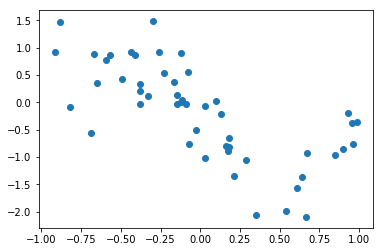

In [4]:
plt.scatter(x,y)

## For a given set of frequency parameters $\omega$ solve the problem using least squares

In this experiment, we will assume that we know the frequency parameters $\omega$ (hence also the dimension $K$). Write a program to find the least squares solution of $\theta$.

Error sum is 
$$\sum_{i=1}^{N}[y_i - A_i\theta]^2$$

$$\theta^* = (A^TA)^{-1}A^Ty$$

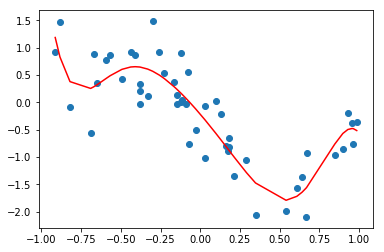

In [5]:
#%matplotlib inline
# Setup the vandermonde matrix
N = len(x)
def make_design_matrix(x, om):
    # Fill this method
    N = len(x)
    K = len(om)
    A = np.hstack((np.hstack((x,np.sin(np.dot(x,om.T)))),np.cos(np.dot(x,om.T))))
    return A

A = make_design_matrix(x.reshape(N,1), om_true)
theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
data = pd.DataFrame(np.hstack((x,np.dot(A,theta))))
data = data.sort_values(by=[0])

plt.scatter(x,y)
plt.plot(data[0],data[1], color= 'red')

## Evaluate and visualize the error as a function of $\omega$ only

This error can be fully visualized for $K=1$ and $K=2$.

Note that for any given $\omega$ we could run the least squares algorithm to find the best $m, \alpha, \beta$ parameters. We will denote the optimal parameters as $\theta^*(\omega) = (m, a, b)^*$. We will exhaustively evaluate the error for all $\omega$ by computing $E(\omega, \theta^*(\omega))$.

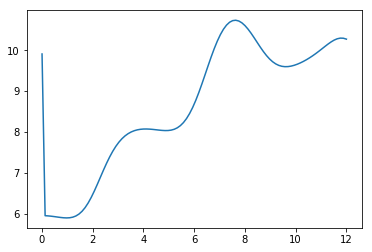

In [6]:
#%matplotlib inline
# Generate different omegas and compute error for each of them.
OM = np.linspace(0.01,12,100)
EE = []

for i in OM:
    A = make_design_matrix(x,np.array(i).reshape(1,1))
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
    e = y - np.dot(A,theta).reshape(len(y),1)
    et = np.transpose(e)
    EE.append(np.dot(et,e)[0]/2)

plt.plot(OM, EE)

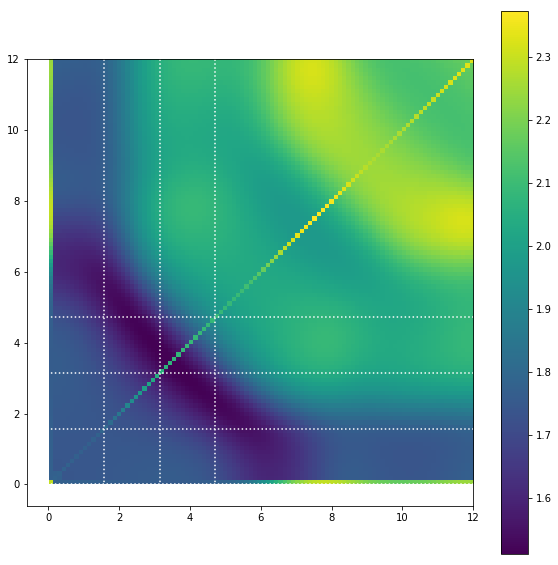

In [7]:
#%matplotlib inline

OM = np.linspace(0.01,12,100)
EE = np.zeros((len(OM),len(OM)))

for i,omega1 in enumerate(OM):
    for j,omega2 in enumerate(OM):
        # Compute the errors for different omega combinations. Do not forget to consider rank defficient design matrix case.
        om_tuple = np.array([omega1, omega2]).reshape(2,1)
        A = make_design_matrix(x,om_tuple)
        theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
        e = y - np.dot(A,theta).reshape(len(y),1)
        et = np.transpose(e)
        EE[i][j]=(np.dot(et,e)[0]/2)

# These lines are for plotting purposes
l = min(OM)
r = max(OM)
plt.figure(figsize=(10,10))
plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')
    

plt.colorbar()
plt.show()

# Question: Stochastic Gradient Descent

For the sinusoidal model, develop a SGD method for estimating $\omega$ as well as the other parameters.

## Derive and implement the expression of the gradient

$$
E_i(m,a,b,\omega) = \frac{1}{2}\left(y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)\right)^2
$$

$$
e_i = y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)
$$

\begin{eqnarray}
\nabla E_i = \left(\begin{array}{c} \frac{\partial E_i}{\partial m} \\ \frac{\partial E_i}{\partial a_1} \\
\vdots \\ \frac{\partial E_i}{\partial a_K} \\  \frac{\partial E_i}{\partial b_1} \\
\vdots \\ \frac{\partial E_i}{\partial b_K} \\  \frac{\partial E_i}{\partial \omega_1} \\
\vdots \\ \frac{\partial E_i}{\partial \omega_K} 
\end{array}
\right) = 
-e_i \left(\begin{array}{c} x_i \\ \sin(\omega_1 x_i) \\ \vdots \\ \sin(\omega_K x_i) \\ 
\cos(\omega_1 x_i) \\ \vdots \\ \cos(\omega_K x_i) \\ a_1 \cos(\omega_k x_i) x_i - b_1 \sin(\omega_1 x_i) x_i \\
\vdots \\ a_K \cos(\omega_K x_i) x_i - b_K \sin(\omega_K x_i) x_i\end{array}
\right)
\end{eqnarray}

In [8]:
# You can fill this function to genrerate the actual model.
def model_fun(x, theta, omega):
    A = make_design_matrix(x, omega)
    return np.dot(A, theta) , A

# You can fill this funtion to compute gradients of the parameters
def grad_fun(y, x, theta, omega, e):
    K = len(omega) 
    N = len(x)
    gm = x.reshape(N,1)
    ga = np.sin(np.dot(x,omega.T))
    gb = np.cos(np.dot(x,omega.T))
    gom = np.multiply(np.cos(np.dot(x,omega.T)),theta.T[0,1:K+1]) - np.multiply(np.sin(np.dot(x,omega.T)),theta.T[0,K+1:2*K+1])
    grad = np.multiply((-1)*e,np.hstack((np.hstack((np.hstack((gm,ga)),gb)),gom)))
    return grad

## Implement SGD

Implement SGD and test it on synthetic data generated in Question 1. 
Show the evolution of the error as a function of iterations.


In [14]:
#%matplotlib inline
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
K_try = 2
ep = 0.01
om = np.array(np.random.rand(K_try)*4*np.pi).reshape(K_try,1)
th = np.array(np.random.randn(K_try*2+1)).reshape(K_try*2+1,1)

def iterateSGD(B, MAX_EPOCH, ep, om, th, plot):
    K_try = 2
    # Initialize
    ERR = []
    OM_PATH = []
    TH_PATH = []
    
    OM_PATH.append(om)
    TH_PATH.append(th)
    for epoch in range(MAX_EPOCH):
        # Implement SGD here
        randindex = np.random.randint(N, size=B)
        y_mini = y[randindex]
        x_mini = x[randindex]
        y_hat, A = model_fun(x_mini,th,om)
        e = y_mini - y_hat
        grad = grad_fun(y_mini, x_mini, th, om, e)
        #print("grad",np.mean(grad[:,0:K_try*2+1], axis=0))
        #print("diff",ep*np.mean(grad[:,0:K_try*2+1], axis=0))
        #print("th",th)
        
        Esq = np.dot(e.T,e)/2
        th = th - ep*np.mean(grad[:,0:K_try*2+1], axis=0).reshape(K_try*2+1,1)
        om = om - ep*np.mean(grad[:,K_try*2+1:K_try*3+1], axis=0).reshape(K_try,1)
        OM_PATH.append(om)
        TH_PATH.append(th)
        ERR.append(Esq[0,0])
    if plot == 1:
        #print("ERR ", ERR)
        # PLot the error as a function of iteratation
        plt.figure(figsize=(10,3))
        plt.xlabel("epoch")
        plt.ylabel("SE")
        plt.plot(ERR)
        plt.show()
    else:
        return om,th,np.array(OM_PATH),np.array(TH_PATH)

om_opt, th_opt, OM_PATH, TH_PATH = iterateSGD(10,5000,ep, om,th,0)


In [13]:
ep = 0.01
interact(iterateSGD, B=(0,50,1) , MAX_EPOCH=(100, 5000, 100), ep=ep, om=fixed(om), th=fixed(th), plot=fixed(1))

interactive(children=(IntSlider(value=25, description='B', max=50), IntSlider(value=2500, description='MAX_EPOCH', max=5000, min=100, step=100), FloatSlider(value=0.01, description='ep', max=0.03, min=-0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.iterateSGD>

## Plot the true function and the fit

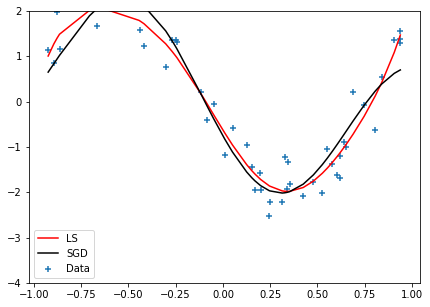

In [10]:
#%matplotlib inline
# Plot data, LS and SGD at once 
def plot_ls_sgd(ax, om_sgd, OM):
    ax.scatter(x,y, marker='+', label = 'Data')
    A_ls = make_design_matrix(x, OM.reshape(len(OM),1))
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A_ls),A_ls)),np.transpose(A_ls)),y)
    data = pd.DataFrame(np.hstack((x,np.dot(A_ls,theta))))
    data = data.sort_values(by=[0])
    plt.plot(data[0],data[1], color= 'red', label='LS')
    th_sgd=np.zeros(om_sgd.shape)
    for i in range(len(OM_PATH)):
        if np.array_equal(OM_PATH[i],om_sgd):
            ix = i
            th_sgd = TH_PATH[ix]
    th_sgd = TH_PATH[np.where(OM_PATH==om_sgd)[0][0]]
    A_sgd = make_design_matrix(x, om_sgd)
    data = pd.DataFrame(np.hstack((x,np.dot(A_sgd,th_sgd))))
    data = data.sort_values(by=[0])
    ax.plot(data[0],data[1], color= 'black', label='SGD')
    ax.set_ylim(-4,2)
    ax.legend()
    
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
plot_ls_sgd(ax1, om_opt, om_true)

## Plot the error surface and plot the path taken by SGD

<IPython.core.display.Javascript object>


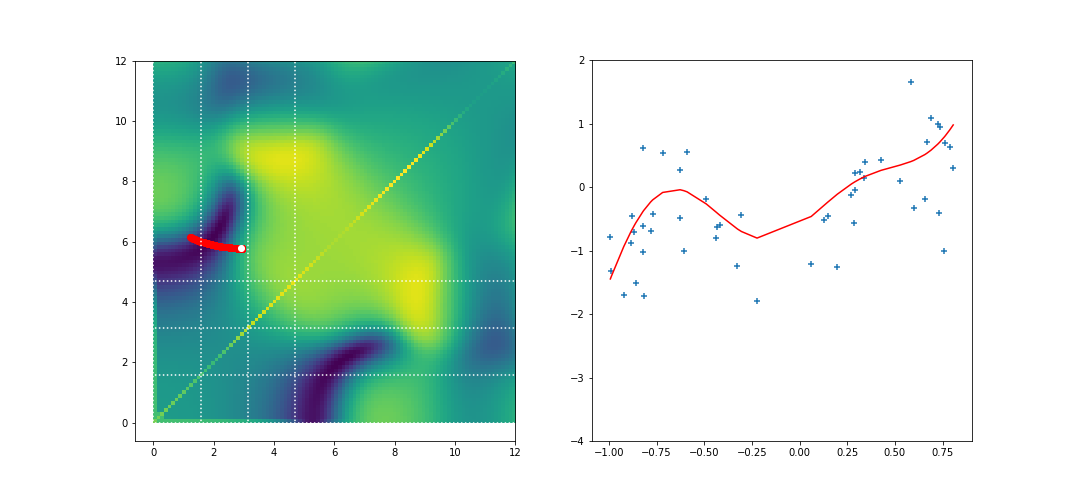

In [348]:
%matplotlib notebook

# These lines are for plotting purposes
l = min(OM)
r = max(OM)
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax1.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')

ax1.scatter(OM_PATH[:-1,0,:], OM_PATH[:-1,1,:], color='red')
ax1.scatter(OM_PATH[-1,0,:], OM_PATH[-1,1,:], color='white')

def onclick(event):
    ax2 = fig.add_subplot(122)
    ax2.cla()
    ax2.set_ylim(-4,2)
    om_current = np.array([[event.xdata],[event.ydata]])
    plot_ls_sgd(ax2, om_current, om_current)
    #plt.scatter(x,y, marker='+', label = 'Data')
    fig.canvas.draw()
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)